**In this Notebook we will design the full graph using 3 tools: search_tool, RAG tool, and SQL-agent for travel database**

In [1]:
import os
from dotenv import load_dotenv
from pyprojroot import here
load_dotenv()

True

Set the environment variables

In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

### **1. initialize the Tools**

**1.1 RAG tool design**

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

EMBEDDING_MODEL = "text-embedding-3-small"
VECTORDB_DIR = str(here("data") / "chroma")
K = 3

@tool
def look_up_comments_table(query:str):
    """
    Look up the comments table for a specific query. Input should be a search query.
    """
    vectordb = Chroma(
    collection_name="comments_energy",
    embedding_function=OpenAIEmbeddings(model=EMBEDDING_MODEL),
    persist_directory=VECTORDB_DIR)

    docs = vectordb.similarity_search(query, k=10)
    return "\n\n".join([doc.page_content for doc in docs])

print(look_up_comments_table)

name='look_up_comments_table' description='Look up the comments table for a specific query. Input should be a search query.' args_schema=<class 'langchain_core.utils.pydantic.look_up_comments_table'> func=<function look_up_comments_table at 0x1056d7240>


Test the RAG tool

In [4]:
res = look_up_comments_table.invoke("which ProductID is related to transition elements and rare element compounds?")
print(res)

ProductID: 040031682,
Structures: nan,
Article Title: Transition Element - Rare Earth Compounds with the Cu5Ca Structure,
General Comments: nan

ProductID: 040031684,
Structures: nan,
Article Title: Transition Element - Rare Earth Compounds with the Cu5Ca Structure,
General Comments: nan

ProductID: 040031685,
Structures: nan,
Article Title: Transition Element - Rare Earth Compounds with the Cu5Ca Structure,
General Comments: nan

ProductID: 040031683,
Structures: nan,
Article Title: Transition Element - Rare Earth Compounds with the Cu5Ca Structure,
General Comments: nan

ProductID: 040041551,
Structures: nan,
Article Title: Laves Phases of the Rare Earths with Transition Elements,
General Comments: nan

ProductID: 040041550,
Structures: nan,
Article Title: Laves Phases of the Rare Earths with Transition Elements,
General Comments: nan

ProductID: 040055049,
Structures: nan,
Article Title: Rare-Earth (and Yttrium)-Iridium and -Platinum Compounds with the Fe3C Structure Type,
General C

**1.2 Search tool design**

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=3)

Test the Search Tool

In [6]:
search_tool.invoke("Can you provide a few links to tutorial videos related to datamining from 'ICDD' dataset?")

[{'title': 'Data Mining in PDF-4+ - ICDD InSession Webinar - YouTube',
  'url': 'https://www.youtube.com/watch?v=ARJSW7Tre1c',
  'content': 'Missing: few links tutorial',
  'score': 0.79769903},
 {'title': '[PDF] Dear Customer - The International Centre for Diffraction Data -',
  'url': 'https://www.icdd.com/assets/tutorials/TechBulletin_Thermal-Expansion.pdf',
  'content': 'Our goal at ICDD is to help you solve your materials problems. We provide online publications, technical bulletins, tutorials, and videos. Many tutorials',
  'score': 0.7555112},
 {'title': 'Navigating a Powder Diffraction File (PDF) Entry - ICDD ... - YouTube',
  'url': 'https://www.youtube.com/watch?v=QgCyl3Y1A68',
  'content': 'Missing: tutorial videos dataset?',
  'score': 0.73981786}]

**1.3 SQL agent tool design**

In [7]:
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_openai import ChatOpenAI

**SQL agent chain**

In [8]:

class ICDDSQLAgentTool:
    """
    A tool for interacting with a ICDD database using an LLM (Language Model) to generate and execute SQL queries.

    This tool enables users to ask questions about compositions, comments, melting points, etc., which are transformed into SQL queries by a language model.
    The SQL queries are executed on the provided ICDD-energy SQLite database, and the results are processed by the language model to
    generate a final answer for the user.

    Attributes:
        sql_agent_llm (ChatOpenAI): An instance of a ChatOpenAI language model used to generate and process SQL queries.
        system_role (str): A system prompt template that guides the language model in answering user questions based on SQL query results.
        db (SQLDatabase): An instance of the SQL database used to execute queries.
        chain (RunnablePassthrough): A chain of operations that creates SQL queries, executes them, and generates a response.

    Methods:
        __init__: Initializes the ICDDSQLAgentTool by setting up the language model, SQL database, and query-answering pipeline.
    """

    def __init__(self, llm: str, sqldb_directory: str, llm_temerature: float) -> None:
        """
        Initializes the ICDDSQLAgentTool with the necessary configurations.

        Args:
            llm (str): The name of the language model to be used for generating and interpreting SQL queries.
            sqldb_directory (str): The directory path where the SQLite database is stored.
            llm_temerature (float): The temperature setting for the language model, controlling response randomness.
        """
        self.sql_agent_llm = ChatOpenAI(
            model=llm, temperature=llm_temerature)
        self.system_role = """Given the following user question, corresponding SQL query, and SQL result, answer the user question.\n
            Question: {question}\n
            SQL Query: {query}\n
            SQL Result: {result}\n
            Answer:
            """
        self.db = SQLDatabase.from_uri(
            f"sqlite:///{sqldb_directory}")
        print(self.db.get_usable_table_names())

        execute_query = QuerySQLDataBaseTool(db=self.db)
        write_query = create_sql_query_chain(
            self.sql_agent_llm, self.db)
        answer_prompt = PromptTemplate.from_template(
            self.system_role)

        answer = answer_prompt | self.sql_agent_llm | StrOutputParser()
        self.chain = (
            RunnablePassthrough.assign(query=write_query).assign(
                result=itemgetter("query") | execute_query
            )
            | answer
        )
        

In [9]:
import sys
from pyprojroot import here
import os
sys.path.append(str(here()))
from src.agent_graph.load_tools_config import LoadToolsConfig
from langchain_core.tools import tool

TOOLS_CFG = LoadToolsConfig()

@tool
def query_icdd_sqldb(query: str) -> str:
    """Query the ICDD-energy SQL Database and access all the energy reltaed materials information. Input should be a search query."""
    agent = ICDDSQLAgentTool(
        llm=TOOLS_CFG.icdd_sqlagent_llm,
        sqldb_directory=TOOLS_CFG.icdd_sqldb_directory,
        llm_temerature=TOOLS_CFG.icdd_sqlagent_llm_temperature
    )
    response = agent.chain.invoke({"question": query})
    return response

In [10]:
query_icdd_sqldb.invoke("How many tables do I have in the database? and what are their names?")

['Applications', 'Comments', 'Compositions', 'Melting Points']


/var/folders/p1/_xzph12174z0rlnng642dchm0000gq/T/ipykernel_42766/11578882.py:40: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=self.db)


"You have 4 tables in the database. Their names are 'Comments', 'Applications', 'Compositions', and 'Melting Points'."

**Wrap up the tools into a list**

In [11]:
tools = [search_tool, look_up_comments_table, query_icdd_sqldb]

#### **Load the LLM for the primary agent and bind it with the tools**

In [27]:
llm = ChatOpenAI(model="gpt-4", temperature=0)
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

### **2. Initialize the Graph State**

Define our StateGraph's state as a typed dictionary containing an append-only list of messages. These messages form the chat history, which is all the state our chatbot needs.

In [28]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### **3. Define the Graph Nodes**

**3.1 First node: chatbot**

In [29]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next, we need to create a function that will run the tools when they are needed. To do this, we'll add the tools to a new node.

In the example below, we'll build a BasicToolNode. This node will check the latest message and, if it contains a request to use a tool, it will run the appropriate tool. This works because many language models (like Anthropic, OpenAI, and Google Gemini) support tool usage.

**3.2 Second node: BasicToolNode that runs the appropriate tool based on the primary agent's output**

In [30]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool, look_up_comments_table, query_icdd_sqldb])
graph_builder.add_node("tools", tool_node)

### **4. Define the entry point and graph edges**

**Aproach 1**

In [31]:
# from typing import Literal


# def route_tools(
#     state: State,
# ) -> Literal["tools", "__end__"]:
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.
#     """
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#         return "tools"
#     return "__end__"


# # The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# # it is fine directly responding. This conditional routing defines the main agent loop.
# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
#     # It defaults to the identity function, but if you
#     # want to use a node named something else apart from "tools",
#     # You can update the value of the dictionary to something else
#     # e.g., "tools": "my_tools"
#     {"tools": "tools", "__end__": "__end__"},
# )
# # Any time a tool is called, we return to the chatbot to decide the next step
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")

**Approach 2**

In [32]:
from langgraph.graph import END, MessagesState
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    ["tools", END],
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### **5. Compile the graph**

- In this step, we can add a memory to our graph as well.

In [33]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

**5.1 Plot the compiled graph**

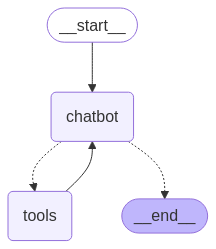

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [35]:
# # 1. Get Mermaid code from LangChain or your graph
# mermaid_code = graph.get_graph().draw_mermaid()

# # 2. Save to file
# with open("graph.mmd", "w") as f:
#     f.write(mermaid_code)

# # 3. Render to PNG using Mermaid CLI (this runs a shell command)
# import subprocess
# subprocess.run(["mmdc", "-i", "graph.mmd", "-o", "graph.png"])

# # 4. Display the generated PNG in Jupyter
# from IPython.display import Image, display
# display(Image("graph.png"))


**Save the graph image**

In [36]:
save = False

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save('output_image.png', 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

### **6. Execute the graph**

In [37]:
config = {"configurable": {"thread_id": "1"}}

**First query**

Approach 1: Print all the steps the the system goes through to get the final output

In [23]:
user_input = "Hi there! My name is Arash."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Arash.
================================== Ai Message ==================================

Hello Arash! How can I assist you today?


Approach 2: Just print the final output

In [38]:
# from langchain_core.messages import HumanMessage
# user_input = "Hi there! My name is Arash."

# # Use the Runnable
# final_state = graph.invoke(
#     {"messages": [HumanMessage(content=user_input)]},
#     config=config
# )
# final_state["messages"][-1].content

**Second query**

In [41]:
user_input = "Is there a table that stores data on zeolite classifications?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Is there a table that stores data on zeolite classifications?
================================== Ai Message ==================================
Tool Calls:
  query_icdd_sqldb (call_MPUxndvo2ZZpnhWrbWf6ewpJ)
 Call ID: call_MPUxndvo2ZZpnhWrbWf6ewpJ
  Args:
    query: SHOW TABLES LIKE '%zeolite%'
['Applications', 'Comments', 'Compositions', 'Melting Points']
================================= Tool Message =================================
Name: query_icdd_sqldb

"The SQL query did not return any results, which means there are no tables with 'zeolite' in their name."
================================== Ai Message ==================================

I'm sorry, but it appears there are no tables in the database that contain 'zeolite' in their name. This suggests that there may not be a specific table storing data on zeolite classifications.


**Third query**

In [ ]:
user_input = "Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
event